In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


In [2]:

# Load the training data
train_data = pd.read_csv('train.csv')


In [3]:
train_data.shape

(10050, 25)

In [5]:
print(train_data.columns)

Index(['ID', 'Tank Failure Pressure (bar)', 'Liquid Ratio (%)',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')


In [7]:

# Ensure there is no zero in 'Tank Length' to avoid division by zero errors
train_data['Tank Length (m)'] = train_data['Tank Length (m)'].replace(0, np.nan)
train_data.dropna(subset=['Tank Length (m)'], inplace=True)  # Drop rows where 'Tank Length' is NaN

# Create a new feature by dividing 'Tank Width' by 'Tank Length'
train_data['Width_Length_Ratio'] = train_data['Tank Height (m)'] / train_data['Tank Length (m)']


In [8]:
# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values in training data:")
print(missing_values)

Missing values in training data:
ID                                  1
Tank Failure Pressure (bar)         1
Liquid Ratio (%)                    1
Tank Width (m)                      1
Tank Length (m)                     0
Tank Height (m)                     1
BLEVE Height (m)                    1
Vapour Height (m)                   1
Vapour Temperature (K)             22
Liquid Temperature (K)             21
Obstacle Distance to BLEVE (m)      1
Obstacle Width (m)                  1
Obstacle Height (m)                 0
Obstacle Thickness (m)              1
Obstacle Angle                      1
Status                              0
Liquid Critical Pressure (bar)     21
Liquid Boiling Temperature (K)     21
Liquid Critical Temperature (K)    21
Sensor ID                           1
Sensor Position Side                1
Sensor Position x                   0
Sensor Position y                   1
Sensor Position z                   1
Target Pressure (bar)               1
Width_Length_Rati

In [9]:

# Function to detect and treat outliers in a dataframe
def detect_treat_outliers(df, column):
    # Calculate the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Applying outlier detection and treatment to all numeric columns in the dataframe
numeric_cols = train_data.select_dtypes(include=['number']).columns
for col in numeric_cols:
    train_data = detect_treat_outliers(train_data, col)

print("Outlier treatment completed. Data preview:")
print(train_data.head())


Outlier treatment completed. Data preview:
       ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0  3203.0                         7.32              0.42            2.42   
1  3204.0                         7.18              0.42            2.39   
2  3205.0                         7.32              0.41            2.39   
3  3206.0                         7.26              0.42            2.40   
4  3207.0                         7.32              0.42            2.40   

   Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0             5.39             1.00              1.79               0.60   
1             5.39             1.01              1.81               0.59   
2             5.38             1.00              1.78               0.62   
3             5.41             1.00              1.81               0.61   
4             5.41             1.02              1.79               0.62   

   Vapour Temperature (K)  Liquid Temperatu

In [10]:
# Remove rows with missing values
train_data_cleaned = train_data.dropna()

# Check the shape of the cleaned dataset
print("Shape of the cleaned dataset:", train_data_cleaned.shape)


Shape of the cleaned dataset: (9938, 26)


In [11]:
# Add Gaussian noise function
def add_noise(data, noise_level=0.01):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        std_dev = data[col].std()
        noise = np.random.normal(loc=0.0, scale=noise_level*std_dev, size=data[col].shape)
        data[col] += noise
    return data

# Add noise to the cleaned data
train_data_noisy = add_noise(train_data_cleaned.copy(), noise_level=0.01)

In [12]:
missing_values = train_data_cleaned.isnull().sum()
print("Missing values in training data:")
print(missing_values)

Missing values in training data:
ID                                 0
Tank Failure Pressure (bar)        0
Liquid Ratio (%)                   0
Tank Width (m)                     0
Tank Length (m)                    0
Tank Height (m)                    0
BLEVE Height (m)                   0
Vapour Height (m)                  0
Vapour Temperature (K)             0
Liquid Temperature (K)             0
Obstacle Distance to BLEVE (m)     0
Obstacle Width (m)                 0
Obstacle Height (m)                0
Obstacle Thickness (m)             0
Obstacle Angle                     0
Status                             0
Liquid Critical Pressure (bar)     0
Liquid Boiling Temperature (K)     0
Liquid Critical Temperature (K)    0
Sensor ID                          0
Sensor Position Side               0
Sensor Position x                  0
Sensor Position y                  0
Sensor Position z                  0
Target Pressure (bar)              0
Width_Length_Ratio                 0
dtype

In [13]:
# Check for duplicate rows in the training data
duplicate_rows = train_data_cleaned[train_data_cleaned.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found in the training data:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the training data.")


Duplicate rows found in the training data:
            ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
10000  10473.0                        31.97              0.60            2.78   
10001   4063.0                        38.55              0.71            2.01   
10002   8593.0                        11.52              0.77            0.42   
10003   8394.0                        10.29              0.21            1.78   
10004   8937.0                        29.55              0.55            1.78   
10005   9468.0                         9.69              0.26            0.78   
10006   3669.0                        34.87              0.69            2.22   
10007   7629.0                        21.61              0.23            2.19   
10008   8781.0                        28.32              0.49            2.78   
10009  11525.0                        40.38              0.83            0.79   
10010   4888.0                        28.87              0.55     

In [14]:
# Remove duplicate rows from the training data
train_data = train_data_cleaned.drop_duplicates()

# Verify that duplicate rows have been removed
print("Duplicate rows removed. Shape of the training data:", train_data.shape)


Duplicate rows removed. Shape of the training data: (9890, 26)


In [15]:
X_train_encoded = pd.get_dummies(train_data)

In [16]:
X_train_encoded

,ID,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),...,Target Pressure (bar),Width_Length_Ratio,Status_Saperheated,Status_Subcoled,Status_Subcool,Status_Subcooled,Status_Superheat,Status_Superheated,Status_subcooled,Status_superheated
0,3203.0,7.32,0.42,2.42,5.39,1.00,1.79,0.60,524.61,354.49,...,0.199929,0.185529,False,False,False,False,False,True,False,False
1,3204.0,7.18,0.42,2.39,5.39,1.01,1.81,0.59,522.80,354.31,...,0.435681,0.187384,False,False,False,False,False,True,False,False
2,3205.0,7.32,0.41,2.39,5.38,1.00,1.78,0.62,523.00,354.59,...,0.264031,0.185874,False,False,False,False,False,True,False,False
3,3206.0,7.26,0.42,2.40,5.41,1.00,1.81,0.61,522.35,354.37,...,0.270576,0.184843,False,False,False,False,False,True,False,False
4,3207.0,7.32,0.42,2.40,5.41,1.02,1.79,0.62,522.98,354.33,...,0.204675,0.188540,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,13198.0,18.09,0.57,2.00,7.19,0.98,0.18,0.39,540.00,319.57,...,0.100168,0.136300,False,False,False,True,False,False,False,False
9996,13199.0,18.18,0.57,1.98,7.19,0.98,0.22,0.41,539.59,318.92,...,0.116293,0.136300,False,False,False,True,False,False,False,False
9997,13200.0,18.21,0.57,1.98,7.19,1.00,0.19,0.39,540.22,319.25,...,0.112795,0.139082,False,False,False,True,False,False,False,False
9998,13201.0,18.41,0.57,1.99,7.19,1.01,0.21,0.41,539.23,318.86,...,0.126599,0.140473,False,False,False,True,False,False,False,False


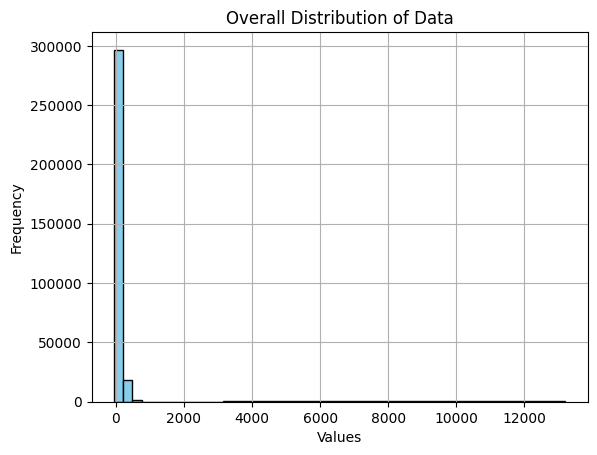

In [17]:
# Flatten the dataframe to convert it into a 1D array
import matplotlib.pyplot as plt
flat_data = X_train_encoded.values.flatten()

# Plot histogram of flattened data
plt.hist(flat_data, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Data')
plt.grid(True)
plt.show()


In [18]:
# if there were too many missing values, we would have replace
# them with median as distribution is right skewed
# Replace missing values with median
#train_data_cleaned_numeric_filled = train_data.fillna(train_data.median())


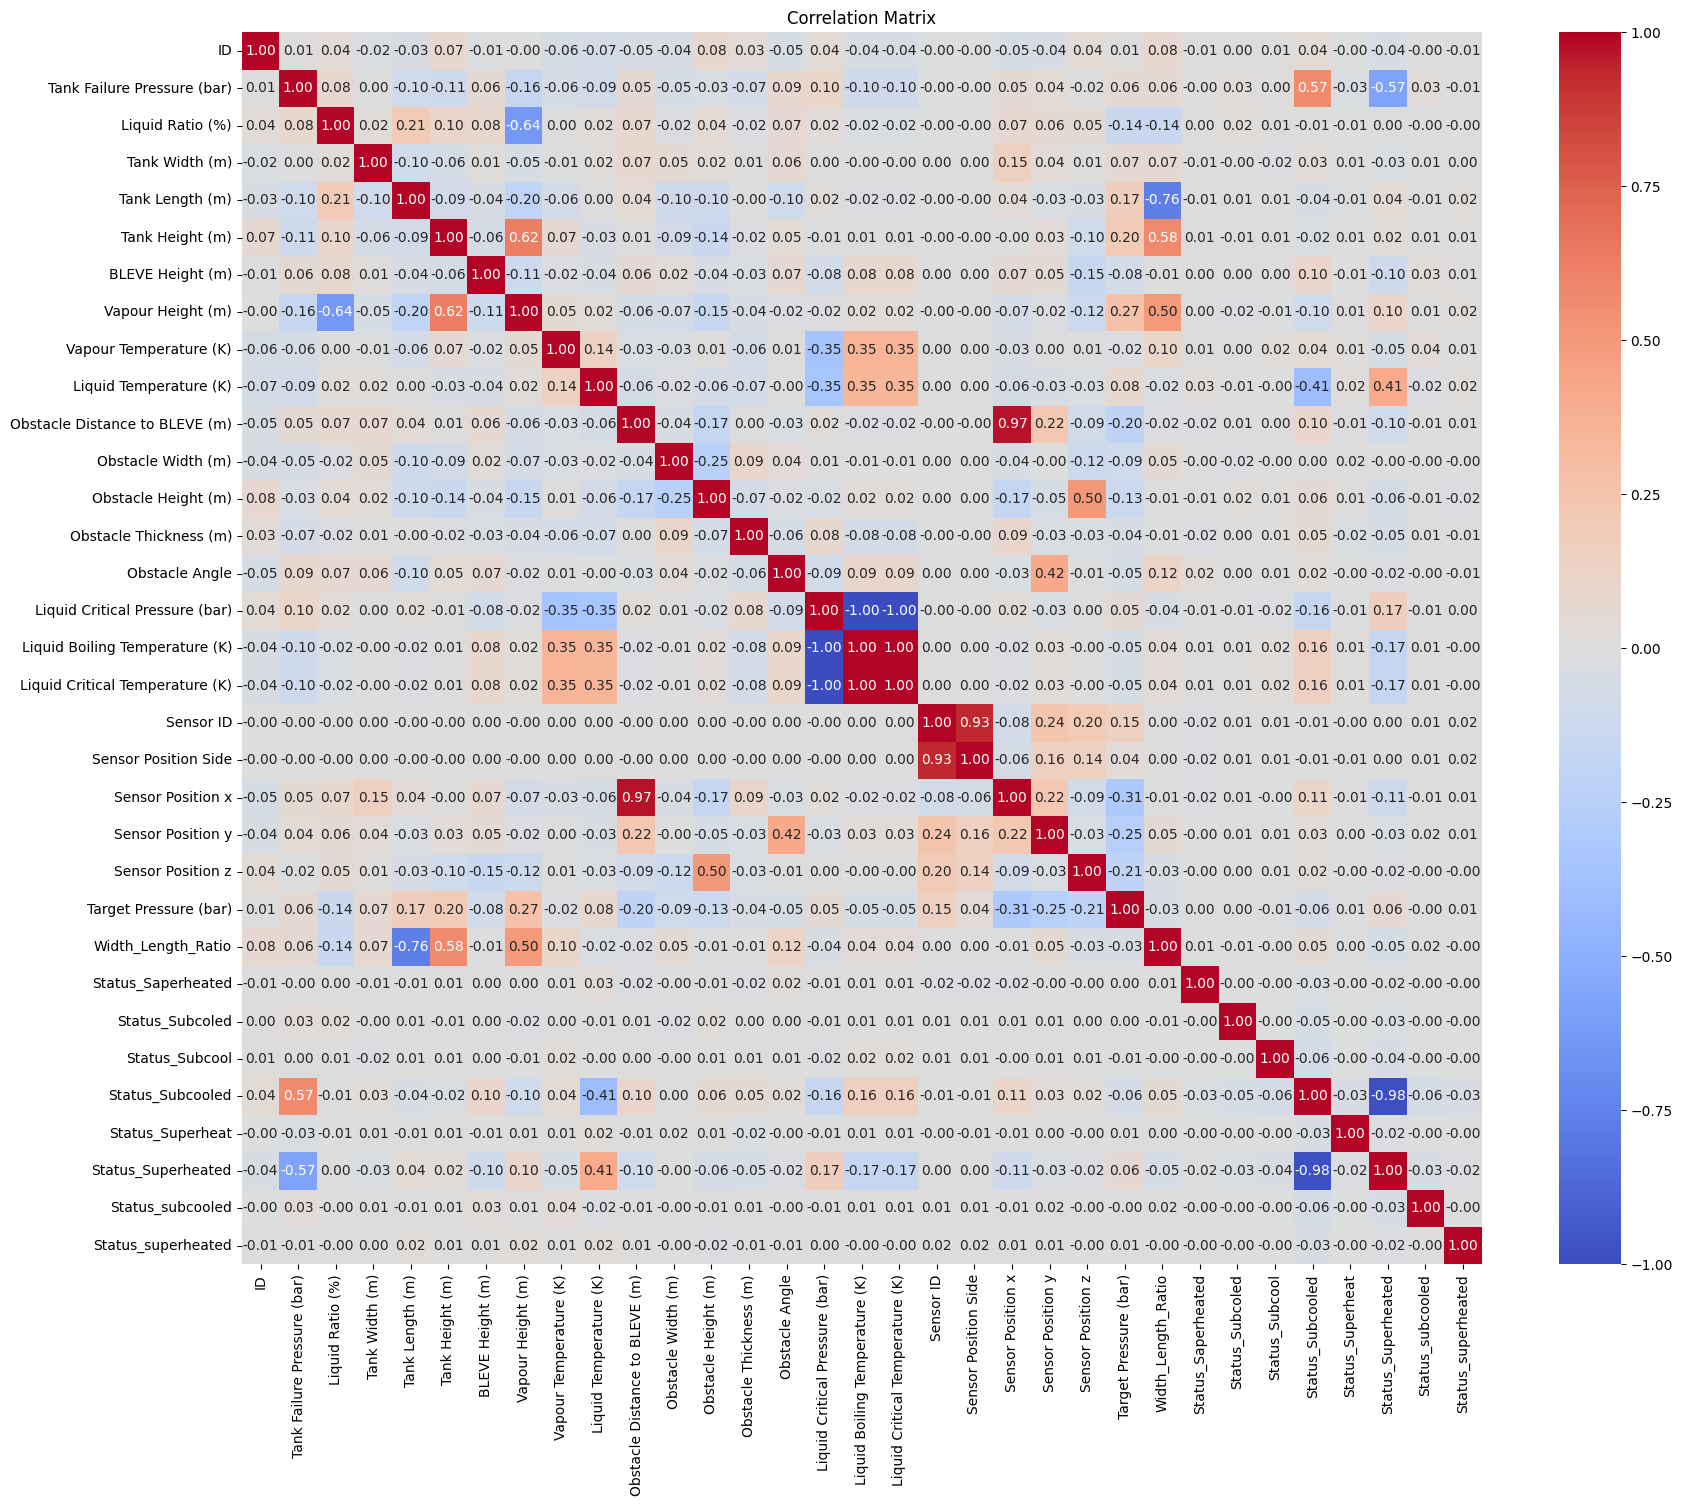

In [19]:
# Calculate correlation matrix
import seaborn as sns
correlation_matrix = X_train_encoded.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [20]:
# Split features and target variable
X = X_train_encoded.drop(columns=['Target Pressure (bar)'])
y = X_train_encoded['Target Pressure (bar)']


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


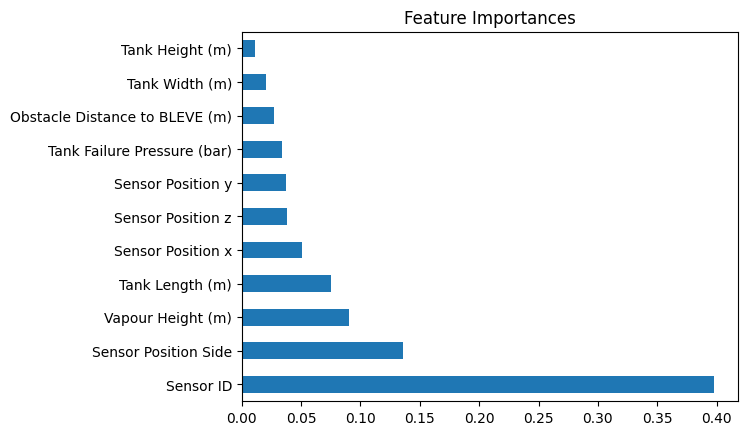

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest model
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Visualize feature importances
feature_importances.nlargest(11).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

In [23]:
top_features = feature_importances.nlargest(11).index.tolist()

In [24]:
# Select the top features from the training and validation datasets
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]

In [47]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)


In [27]:
# Model Development
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'DecisionTree' : DecisionTreeRegressor()
}


In [58]:
# Define hyperparameter grids for each model, updated 'max_features' for Random Forest
param_grids = {
    'Linear Regression': {'fit_intercept': [True, False]},
    'Random Forest': {'n_estimators': [100, 200], 'max_features': ['sqrt',None], 'max_depth': [None, 10, 20]},
    'SVR': {'C': [1, 10], 'kernel': ['linear', 'rbf']},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]},
    'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 10]}
}

best_model = None
best_model_name = ''
best_score = float('inf')


In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
for name, model in models.items():
    print(f"Training {name}...")
    #model.fit(X_train_scaled, y_train)
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Best model from grid search
    model = grid_search.best_estimator_

    # Model Evaluation
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"{name} Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"R2 Score: {r2}")
    print()  # Add an empty line for spacing

    if mse < best_score:
        best_score = mse
        best_model = model
        best_model_name = name

print(f"Best Model: {best_model_name}")

Training Linear Regression...
Linear Regression Metrics:
Mean Squared Error: 0.022790311039580995
Mean Absolute Error: 0.11635201094582831
Best Parameters: {'fit_intercept': True}
R2 Score: 0.6504527694844895

Training Random Forest...
Random Forest Metrics:
Mean Squared Error: 0.004199615410329244
Mean Absolute Error: 0.041288772787438054
Best Parameters: {'max_depth': None, 'max_features': None, 'n_estimators': 200}
R2 Score: 0.9355882447869464

Training SVR...
SVR Metrics:
Mean Squared Error: 0.005322175350260645
Mean Absolute Error: 0.05723975716647481
Best Parameters: {'C': 10, 'kernel': 'rbf'}
R2 Score: 0.9183709405821374

Training Gradient Boosting...
Gradient Boosting Metrics:
Mean Squared Error: 0.0041019273447324
Mean Absolute Error: 0.043855810202280326
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R2 Score: 0.9370865390719383

Training XGBoost...
XGBoost Metrics:
Mean Squared Error: 0.004024590021611526
Mean Absolute Error: 0.04332366590776894

In [61]:
# Load the test data
test_data = pd.read_csv('test.csv')

In [62]:
test_data.shape

(3203, 24)

In [63]:
# Check for missing values
missing_values = test_data.isnull().sum()
print("Missing values in training data:")
print(missing_values)

Missing values in training data:
ID                                 0
Tank Failure Pressure (bar)        0
Liquid Ratio (%)                   0
Tank Width (m)                     0
Tank Length (m)                    0
Tank Height (m)                    0
BLEVE Height (m)                   0
Vapour Height (m)                  0
Vapour Temperature (K)             0
Liquid Temperature (K)             0
Obstacle Distance to BLEVE (m)     0
Obstacle Width (m)                 0
Obstacle Height (m)                0
Obstacle Thickness (m)             0
Obstacle Angle                     0
Status                             0
Liquid Critical Pressure (bar)     0
Liquid Boiling Temperature (K)     0
Liquid Critical Temperature (K)    0
Sensor ID                          0
Sensor Position Side               0
Sensor Position x                  0
Sensor Position y                  0
Sensor Position z                  0
dtype: int64


In [64]:
# Check for duplicate rows in the training data
duplicate_rows = test_data[test_data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found in the training data:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the training data.")


No duplicate rows found in the training data.


In [68]:
X_test_encoded = pd.get_dummies(test_data)

In [67]:
X_test_encoded

,ID,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),...,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor ID,Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Status_Subcooled,Status_Superheated
0,0,16.8,0.336426,2.8,8.6,2.2,0.4,1.6,389.9,387.2,...,37.9,-1,152.0,1,1,12.05,-5.6,-1.0,False,True
1,1,16.8,0.336426,2.8,8.6,2.2,0.4,1.6,389.9,387.2,...,37.9,-1,152.0,2,1,12.05,-5.6,1.3,False,True
2,2,16.8,0.336426,2.8,8.6,2.2,0.4,1.6,389.9,387.2,...,37.9,-1,152.0,3,1,12.05,-5.6,3.6,False,True
3,3,16.8,0.336426,2.8,8.6,2.2,0.4,1.6,389.9,387.2,...,37.9,-1,152.0,4,1,12.05,0.2,-1.0,False,True
4,4,16.8,0.336426,2.8,8.6,2.2,0.4,1.6,389.9,387.2,...,37.9,-1,152.0,5,1,12.05,0.2,1.3,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,3198,7.3,0.415800,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,37.9,-1,152.0,13,2,12.15,2.6,-1.9,False,True
3199,3199,7.3,0.415800,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,37.9,-1,152.0,14,2,12.15,2.6,4.4,False,True
3200,3200,7.3,0.415800,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,37.9,-1,152.0,15,2,12.15,2.6,10.7,False,True
3201,3201,7.3,0.415800,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,37.9,-1,152.0,16,2,12.15,7.9,-1.9,False,True


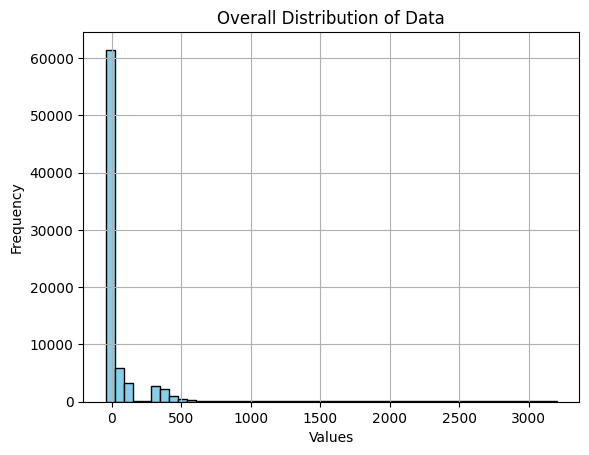

In [69]:
# Flatten the dataframe to convert it into a 1D array
import matplotlib.pyplot as plt
flat_data = X_test_encoded.values.flatten()

# Plot histogram of flattened data
plt.hist(flat_data, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Data')
plt.grid(True)
plt.show()


In [70]:
# Assuming top_features contains the top feature names
test_data_subset = test_data[top_features]

# Scale the subset of test data
test_data_scaled = scaler.transform(test_data_subset)


In [71]:
print (test_data_scaled )

[[-1.66389676 -0.99522754  1.42266031 ... -0.2978489   1.44621696
   0.6965439 ]
 [-1.53508693 -0.99522754  1.42266031 ... -0.2978489   1.44621696
   0.6965439 ]
 [-1.4062771  -0.99522754  1.42266031 ... -0.2978489   1.44621696
   0.6965439 ]
 ...
 [ 0.13944087 -0.24004961 -0.46091068 ... -0.04970943  0.92352814
  -0.89748672]
 [ 0.26825071 -0.24004961 -0.46091068 ... -0.04970943  0.92352814
  -0.89748672]
 [ 0.39706054 -0.24004961 -0.46091068 ... -0.04970943  0.92352814
  -0.89748672]]


In [72]:
test_predictions = best_model.predict(test_data_scaled)

# Display test predictions
print("Test Predictions:")
print(test_predictions)

Test Predictions:
[0.26538864 0.27567673 0.3300878  ... 0.3668596  0.39613283 0.2636331 ]


In [73]:
for prediction in test_predictions:
    print(prediction)

0.26538864
0.27567673
0.3300878
0.30572113
0.2952661
0.25110993
0.1921504
0.19905147
0.24712023
0.8441425
0.8725009
0.88371295
0.96597254
0.96485937
0.946513
0.8559025
0.8570383
0.77889836
0.729479
0.73684067
0.6720405
0.5836604
0.55015546
0.42985582
0.41378304
0.42455065
0.4289232
0.04234235
0.034065943
0.032175034
0.041751407
0.021984823
0.01389804
0.024545886
0.018485267
0.01737008
0.37063092
0.21834303
0.09723746
0.5438962
0.3154748
0.18236357
0.37435475
0.29976997
0.14759111
0.12434994
0.07403968
0.02916166
-0.022857096
0.00829566
0.011310105
0.06946359
0.035608515
0.015480298
0.17928909
0.18186924
0.15080313
0.16724889
0.16185202
0.11385983
0.12613618
0.13660687
0.12453789
0.7758029
0.73805773
0.5229514
0.7684576
0.7187628
0.51741385
0.7022978
0.6009524
0.39978462
0.58381736
0.55540967
0.3870512
0.33024785
0.24202076
0.22911803
0.31228426
0.30874646
0.220628
0.10144456
0.098932706
0.11993651
0.06666566
0.055832718
0.05010893
0.038103964
0.035148665
0.040520843
0.46440962
0.444044

In [75]:
import pandas as pd

# Load test data
test_data = pd.read_csv('test.csv')

# Add predictions to the test data DataFrame
test_data['Predictions'] = test_predictions

# Display all rows of test data with predictions
with pd.option_context('display.max_rows', None):
    print(test_data[['ID', 'Predictions']])


test_data[['ID', 'Predictions']].to_csv('predictions.csv', index=False)

        ID  Predictions
0        0     0.265389
1        1     0.275677
2        2     0.330088
3        3     0.305721
4        4     0.295266
5        5     0.251110
6        6     0.192150
7        7     0.199051
8        8     0.247120
9        9     0.844142
10      10     0.872501
11      11     0.883713
12      12     0.965973
13      13     0.964859
14      14     0.946513
15      15     0.855902
16      16     0.857038
17      17     0.778898
18      18     0.729479
19      19     0.736841
20      20     0.672041
21      21     0.583660
22      22     0.550155
23      23     0.429856
24      24     0.413783
25      25     0.424551
26      26     0.428923
27      27     0.042342
28      28     0.034066
29      29     0.032175
30      30     0.041751
31      31     0.021985
32      32     0.013898
33      33     0.024546
34      34     0.018485
35      35     0.017370
36      36     0.370631
37      37     0.218343
38      38     0.097237
39      39     0.543896
40      40     0